# 3.1 Jednoduchý klasifikátor na základe závislosti v dátach  (5b)

In [140]:
import pandas as pd
from pathlib import Path
import numpy as np
folder = Path("./070")

# Načítanie dát
train_data = pd.read_csv(folder / 'train_data.csv')
test_data = pd.read_csv(folder / "test_data.csv")

In [141]:
# Rozdelenie na vstupy (X) a cieľovú premennú (y)
X_train = train_data[['p.katana', 'p.android.gm', 'p.android.documentsui']].to_numpy()
y_train = train_data['mwra'].to_numpy()

## (A-3b) Naimplementujte jednoduchý ID3 klasifikátor s hĺbkou min 2 (vrátane root/koreň). 


In [142]:
# funkcia na vypocet entropy podla vzorca
def entropy(y):
    counts = np.bincount(y.astype(int))
    probabilities = counts / len(y)
    return -np.sum([p * np.log2(p) for p in probabilities if p > 0])

# Funkcia na výpočet informačného zisku podla vzorca
def information_gain(X, y, feature_index):
    total_entropy = entropy(y)
    values, counts = np.unique(X[:, feature_index], return_counts=True)
    weighted_entropy = np.sum([(counts[i] / np.sum(counts)) * entropy(y[X[:, feature_index] == values[i]])
                               for i in range(len(values))])
    return total_entropy - weighted_entropy


In [143]:
# Implementacia nasho ID3 Klasifikatora

# pseudokod z https://www.geeksforgeeks.org/sklearn-iterative-dichotomiser-3-id3-algorithms/

# def ID3(D, A):
#   if D is pure or A is empty:
#     return a leaf node with the majority class in D
#   else:
#     A_best = argmax(InformationGain(D, A))
#     root = Node(A_best)
#     for v in values(A_best):
#       D_v = subset(D, A_best, v)
#       child = ID3(D_v, A - {A_best})
#       root.add_child(v, child)
#     return root

# ID3 Klasifikátor
class ID3Tree:
    def __init__(self, max_depth=2):
        self.max_depth = max_depth
        self.tree = {}

    def fit(self, X, y, depth=0):
        # Skonči, ak je hĺbka >= max_depth alebo všetky vzorky majú rovnakú triedu
        if depth >= self.max_depth or len(np.unique(y)) == 1:
            return np.argmax(np.bincount(y.astype(int)))
        
        # Vyber atribút s najvyšším informačným ziskom
        best_feature = np.argmax([information_gain(X, y, i) for i in range(X.shape[1])])
        tree = {best_feature: {}}
        
        # Rozdeľ dáta podľa hodnôt najlepšieho atribútu
        values = np.unique(X[:, best_feature])
        for value in values:
            subset_X = X[X[:, best_feature] == value]
            subset_y = y[X[:, best_feature] == value]
            tree[best_feature][value] = self.fit(subset_X, subset_y, depth + 1)
        
        self.tree = tree
        return tree

    def predict_one(self, x):
        node = self.tree
        while isinstance(node, dict):
            feature = list(node.keys())[0]
            value = x[feature]
            node = node[feature].get(value, np.argmax(np.bincount(y.astype(int))))
        return node

    def predict(self, X):
        return np.array([self.predict_one(x) for x in X])



In [144]:
# Trénovanie ID3 klasifikátora
id3_tree = ID3Tree(max_depth=2)
idk = id3_tree.fit(X_train, y_train)

## (B-1b) Vyhodnoťte Váš ID3 klasifikátor pomocou metrík accuracy, precision a recall.


In [145]:
# Vyhodnotenie metriky
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Rozdelenie testovacích dát na vstupy a cieľovú premennú
X_test = test_data[['p.katana', 'p.android.gm', 'p.android.documentsui']].to_numpy()
y_test = test_data['mwra'].to_numpy()

# Predikcie na tréningovej množine
y_train_pred = id3_tree.predict(X_train)

# Predikcie na testovacej množine
y_test_pred = id3_tree.predict(X_test)

# Výpočet metrík pre tréningové dáta
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)

# Výpočet metrík pre testovacie dáta
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)

# Zobrazenie výsledkov
print("Tréningová množina:")
print(f"  Accuracy: {train_accuracy:.2f}")
print(f"  Precision: {train_precision:.2f}")
print(f"  Recall: {train_recall:.2f}")

print("\nTestovacia množina:")
print(f"  Accuracy: {test_accuracy:.2f}")
print(f"  Precision: {test_precision:.2f}")
print(f"  Recall: {test_recall:.2f}")


Tréningová množina:
  Accuracy: 1.00
  Precision: 1.00
  Recall: 1.00

Testovacia množina:
  Accuracy: 0.65
  Precision: 0.65
  Recall: 1.00


## (C-1b) Zístite či Váš ID3 klasifikátor má overfit.

In [146]:
# Výsledky ukazujú, že náš model ID3 klasifikátora trpí overfittingom.
# Toto je evidentné z nasledujúcich pozorovaní:

# - Tréningová množina:

# Accuracy, Precision a Recall = 1.00: Model dosahuje dokonalé výsledky na tréningových dátach,
# čo naznačuje, že model „zapamätal“ dáta a nie je schopný generalizovať.

# - Testovacia množina:

# Accuracy = 0.65 a Precision = 0.65: Model má problémy s predikciou na nevidených dátach.
# Recall = 1.00: Model vždy správne identifikuje všetky pozitívne prípady, ale pri tom pravdepodobne
# označuje veľa negatívnych prípadov ako pozitívne, čo znižuje presnosť (precision).

# 3.2 Trénovanie a vyhodnotenie klasifikátorov strojového učenia (5b)


## (A-1b) Na trénovanie využite jeden stromový algoritmus v scikit-learn.


In [147]:
from sklearn.tree import DecisionTreeClassifier

# Vytvorenie a trénovanie Decision Tree Classifier
tree_clf = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_clf.fit(X_train, y_train)

# Predikcie na testovacích dátach
y_test_pred_tree = tree_clf.predict(X_test)

## (B-1b) Porovnajte s jedným iným nestromovým algoritmom v scikit-learn.

In [148]:
from sklearn.linear_model import LogisticRegression

# Vytvorenie a trénovanie Logistic Regression Classifier
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train, y_train)

# Predikcie na testovacích dátach
y_test_pred_log_reg = log_reg.predict(X_test)



## (C-1b) Porovnajte výsledky s ID3 z prvého kroku.

In [149]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Všetky predikcie
y_test_pred_id3 = id3_tree.predict(X_test)

# Výpočet metrík pre každý model
models = {
    "ID3": y_test_pred_id3,
    "Decision Tree": y_test_pred_tree,
    "Logistic Regression": y_test_pred_log_reg
}

print("Porovnanie výsledkov na testovacích dátach:")
for model_name, y_pred in models.items():
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    print(f"{model_name}:")
    print(f"  Accuracy: {accuracy:.2f}")
    print(f"  Precision: {precision:.2f}")
    print(f"  Recall: {recall:.2f}\n")


Porovnanie výsledkov na testovacích dátach:
ID3:
  Accuracy: 0.65
  Precision: 0.65
  Recall: 1.00

Decision Tree:
  Accuracy: 0.85
  Precision: 0.88
  Recall: 0.88

Logistic Regression:
  Accuracy: 0.86
  Precision: 0.87
  Recall: 0.92




## (D-1b) Vizualizujte natrénované pravidlá minimálne pre jeden Vami vybraný algoritmus

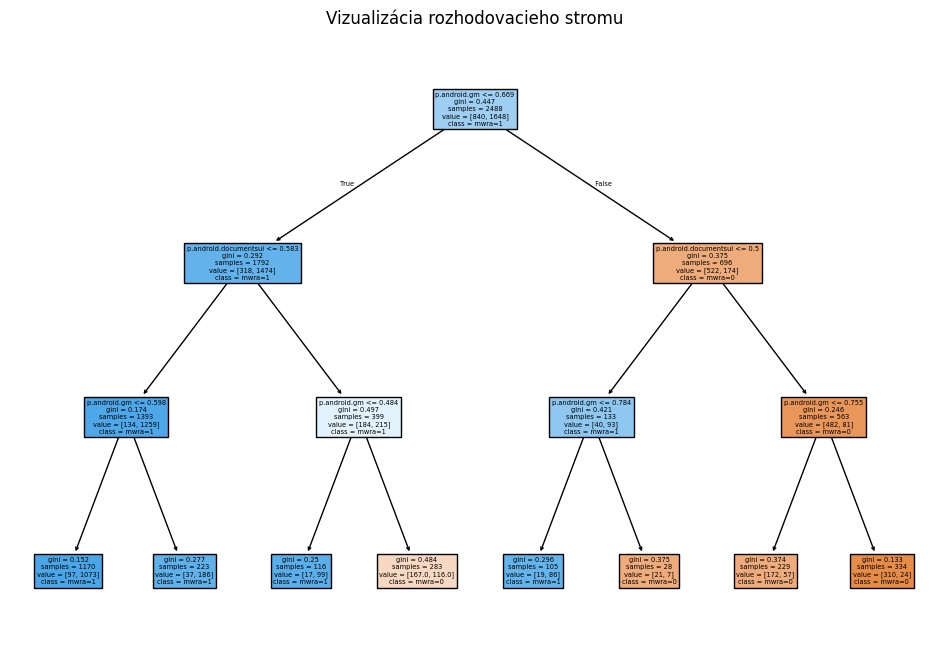

In [150]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Vizualizácia rozhodovacieho stromu
plt.figure(figsize=(12, 8))
plot_tree(tree_clf, feature_names=['p.katana', 'p.android.gm', 'p.android.documentsui'], class_names=['mwra=0', 'mwra=1'], filled=True)
plt.title("Vizualizácia rozhodovacieho stromu")
plt.show()



## (E-1b) Vyhodnoťte natrénované modely pomocou metrík accuracy, precision a recall

In [151]:
# Toto je zahrnute v 3.2 c)

# 3.3 Optimalizácia alias hyperparameter tuning (5b)



## (A-1b) Vyskúšajte rôzne nastavenie hyperparametrov (tuning) pre zvolený algoritmus tak, aby ste optimalizovali výkonnosť (bez underfitingu).


In [152]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Nastavenie hyperparametrov na skúšanie
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Inicializácia modelu
dt_model = DecisionTreeClassifier(random_state=42)

# Použitie GridSearchCV
grid_search = GridSearchCV(estimator=dt_model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)

# Najlepšie parametre
print("Najlepšie hyperparametre:", grid_search.best_params_)
best_dt_model = grid_search.best_estimator_

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Najlepšie hyperparametre: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10}


## (B-1b) Vyskúšajte kombinácie modelov (ensemble) pre zvolený algoritmus tak, aby ste optimalizovali výkonnosť (bez underfitingu) . 


In [155]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

# Ensemble: Bagging s DecisionTree
bagging_model = BaggingClassifier(estimator=DecisionTreeClassifier(random_state=42), n_estimators=50, random_state=42)
bagging_model.fit(X_train, y_train)

# Ensemble: Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Vyhodnotenie na testovacích dátach
bagging_accuracy = bagging_model.score(X_test, y_test)
rf_accuracy = rf_model.score(X_test, y_test)

print(f"Bagging accuracy: {bagging_accuracy:.2f}")
print(f"Random Forest accuracy: {rf_accuracy:.2f}")


Bagging accuracy: 0.85
Random Forest accuracy: 0.85


## (C-1b) Využite krížovú validáciu (cross validation) na trénovacej množine.


In [156]:
from sklearn.model_selection import cross_val_score

# Cross-validation pre DecisionTreeClassifier
cv_scores = cross_val_score(best_dt_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"Priemerná presnosť po krížovej validácii: {cv_scores.mean():.2f}")

# Cross-validation pre RandomForestClassifier
rf_cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"Priemerná presnosť po krížovej validácii pre Random Forest: {rf_cv_scores.mean():.2f}")


Priemerná presnosť po krížovej validácii: 0.85
Priemerná presnosť po krížovej validácii pre Random Forest: 0.84


## (D-2b) Dokážte že Váš nastavený najlepší model je bez overfitingu.

In [157]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Predikcie na trénovacích dátach
y_train_pred = best_dt_model.predict(X_train)

# Predikcie na testovacích dátach
y_test_pred = best_dt_model.predict(X_test)

# Výpočet metrík pre trénovaciu množinu
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)

# Výpočet metrík pre testovaciu množinu
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)

# Výstup
print("Trénovacia množina:")
print(f"  Accuracy: {train_accuracy:.2f}, Precision: {train_precision:.2f}, Recall: {train_recall:.2f}")

print("\nTestovacia množina:")
print(f"  Accuracy: {test_accuracy:.2f}, Precision: {test_precision:.2f}, Recall: {test_recall:.2f}")

# Posúdenie, či je model overfit
if train_accuracy - test_accuracy > 0.1:
    print("Model je overfit.")
else:
    print("Model nie je overfit.")


Trénovacia množina:
  Accuracy: 0.87, Precision: 0.89, Recall: 0.91

Testovacia množina:
  Accuracy: 0.85, Precision: 0.87, Recall: 0.90
Model nie je overfit.


# 3.4 Vyhodnotenie vplyvu zvolenej stratégie riešenia na klasifikáciu (5b) 
Vyhodnoťte Vami zvolené stratégie riešenia projektu z hľadiska classification accuracy, či sú učinné pre Váš dataset: 


## (A-1b) Stratégie riešenia chýbajúcich hodnôt a outlierov


## (B-1b) Dátová transformácia (scaling, transformer, …)


## (C-1b) Výber atribútov, výber algoritmov, hyperparameter tuning, ensemble learning


## (D-1b) Ktorý model je Váš najlepší model pre nasadenie (deployment)? 


## (E-1b) Aký je data pipeline pre jeho vybudovanie na základe Vášho datasetu v produkcii?
